<h1>SIT307 Group Assignment 1 notebook</h1>

<h3>Group 3</h3>
<p>By:<br>
    Aaron Norwood,218330434<br>
    Joshua Anthony, 219466473<br>
    Roger Middenway, 217602784<br>
    David Adams, 216110104<br>
    Linden Hutchinson, 218384326<br>
    Dale Orders, 219106283

# Imported libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
# import plotly.express as px
%matplotlib inline

from sklearn.metrics import cohen_kappa_score, roc_curve, f1_score, make_scorer

<h3> Read in the data, store if dataframe

In [2]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

<h4>Tidying

In [3]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

# print(len(df[df['gender'] == 'other']))
## drop the one row that has "other" gender to keep things simple
df.drop(index=df[df['gender'] == 'other'].index, inplace=True)

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

## round off age
df['age'] = df['age'].apply(lambda x : round(x))

# cap BMI outliers to a maximum of 60 
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h4>Imputing

In [4]:
m_df = df[df['gender'] == 'male']
f_df = df[df['gender'] == 'female']

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 'male':
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]

In [5]:
residence_type_map = {
    'urban':0,
    'rural':1
}
df['residence_type'] = df['residence_type'].map(residence_type_map)
# replace marital status with binary values
df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})
# replace gender with binary values
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

<h4>Binning

In [6]:
# implement age bins
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)

# implement glucose bins
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# implement bmi bins
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)

In [7]:
def add_dummy(target_df, origin_df, col):
    abbrev = col[:2] + '_'
    for cat in origin_df[col].value_counts().index.tolist()[1:]:
        target_df[abbrev + str(cat)] = origin_df[col] == cat
        target_df[abbrev + str(cat)] = target_df[abbrev + str(cat)].map({False: 0, True: 1})


In [8]:
df_dummies = pd.DataFrame(index=df.index)

add_dummy(df_dummies, df, 'work_type')
add_dummy(df_dummies, df, 'smoking_status')
add_dummy(df_dummies, df, 'age_bin')
add_dummy(df_dummies, df, 'avg_glucose_level_bin')
add_dummy(df_dummies, df, 'bmi_bin')

In [9]:
to_add = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'stroke']
df_dummies[to_add] = df[to_add]

## Dummy dataset creation
I created a dummy dataset as i thought it might perform well for this model, although SVM's can take a wide range of data types apparently

In [10]:
df_dummies.head()

,wo_self-employed,wo_children,wo_govt-job,wo_never-worked,sm_unknown,sm_formerly-smoked,sm_smokes,"ag_(20.0, 30.0]","ag_(-0.1, 11.0]","ag_(30.0, 38.0]",...,"bm_(38.6, 59.7]","bm_(26.6, 28.2]","bm_(19.8, 22.6]","bm_(31.8, 34.2]",gender,hypertension,heart_disease,ever_married,residence_type,stroke
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,1,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,1,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1


In [11]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from IPython.display import clear_output

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop(['stroke'], axis=1), df_dummies['stroke'], test_size=0.33, random_state=42)

In [13]:
X = df_dummies.drop(['stroke'], axis=1)
y = df_dummies['stroke']
# skf = StratifiedKFold(n_splits=3)

def run_svm(X, y, w1, w2, splits, repeats, scorer):
    weights = {0:w1, 1:w2}
    model = SVC(gamma='scale', class_weight=weights)

    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=1)

    scores = cross_val_score(model, X, y, scoring=scorer, cv=cv, n_jobs=-1)
    
    return scores


## Grid search
This cell searches through different class weight combinations

In [14]:
scoreses = []
parameses = []
top_score = 0
top_params = {}

weights = [0.05, 0.1, 0.25, 0.5, 1, 2, 5, 10]
splits = [3]
repeats = 5

kappa_scorer = make_scorer(cohen_kappa_score)
mean_roc = 'roc_auc'

for a in weights:
    for b in weights:
        for c in splits:
            scores = run_svm(X, y, a, b, c, repeats, mean_roc)
            perf = np.mean(scores)
            params = {'w1': a, 'w2': b, 'splits': c, 'score': perf}
            clear_output(wait=True)
            if perf > top_score:
                top_score = perf
                top_params = params
                print(f'Score: {perf:.3f} - new best')
            else:
                print(f'Score: {perf:.3f} - top score is {top_score:.3f}')
            scoreses.append(scores)
            parameses.append(params)

Score: 0.658 - top score is 0.818


In [15]:
top_params

{'w1': 0.05, 'w2': 1, 'splits': 3, 'score': 0.8181746740046606}

In [16]:
res = pd.DataFrame(parameses)

## All of this to show that a ratio of 20:1 is the best

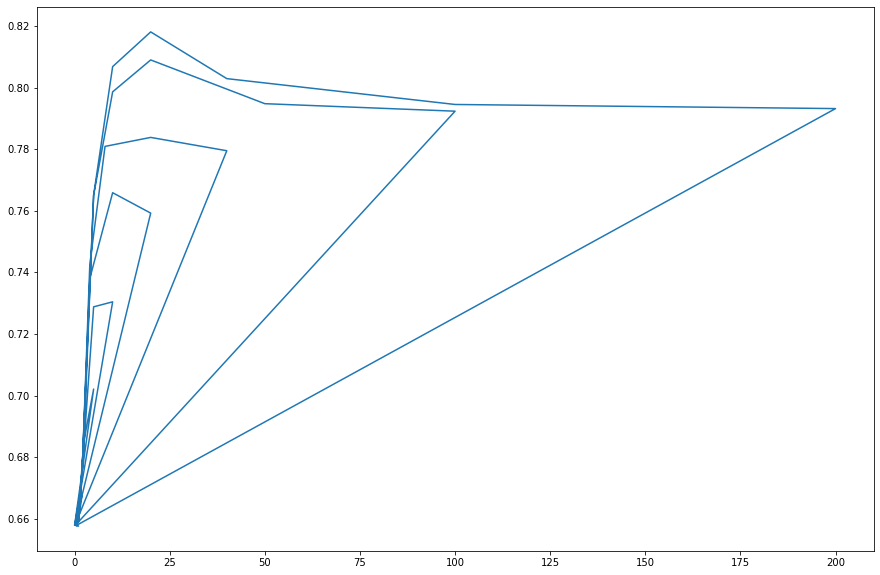

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))

for i in res['splits'].value_counts().index:
    temp_df = res[res['splits'] == i]
    ax.plot(temp_df['w2']/temp_df['w1'], temp_df['score'])

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [19]:
weights = {0:0.05, 1:1.0}
model = SVC(gamma='scale', class_weight=weights)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)

model.fit(X_train, y_train)

y_true = y_test
y_pred = model.predict(X_test)

In [21]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)

In [22]:
scores.mean()

0.23737034660528733

## Results from dummy dataset

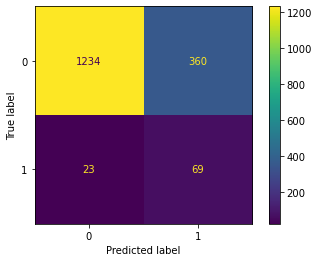

In [23]:
# plot_confusion_matrix(model, X_test, y_test)
plot_confusion_matrix(model, X_test, y_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.77      0.87      1594
           1       0.16      0.75      0.26        92

    accuracy                           0.77      1686
   macro avg       0.57      0.76      0.57      1686
weighted avg       0.94      0.77      0.83      1686



## Selecting features
Now i selected the features we had identified as the most significant: age, average glucose level, hypertension and heart disease

In [25]:
selected_columns = ['ag_(20.0, 30.0]',
       'ag_(-0.1, 11.0]', 'ag_(30.0, 38.0]', 'ag_(38.0, 45.0]',
       'ag_(51.0, 57.0]', 'ag_(65.0, 75.0]', 'ag_(11.0, 20.0]',
       'ag_(75.0, 82.0]', 'ag_(45.0, 51.0]', 'av_(80.0, 85.6]',
       'av_(65.8, 73.8]', 'av_(192.2, 271.7]', 'av_(124.1, 192.2]',
       'av_(55.0, 65.8]', 'av_(108.5, 124.1]', 'av_(91.9, 98.9]',
       'av_(85.6, 91.9]', 'av_(73.8, 80.0]', 'hypertension', 'heart_disease', 'stroke']
df_dummies_pruned = df_dummies[selected_columns]

In [26]:
X = df_dummies_pruned.drop(['stroke'], axis=1)
y = df_dummies_pruned['stroke']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)

weights = {0:0.05, 1:1}
model = SVC(gamma='scale', class_weight=weights)

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [28]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)

In [29]:
scores.mean()

0.22505753466093809

## Pruned dummy dataset results
Only slightly better recall, and slightly fewer false positives

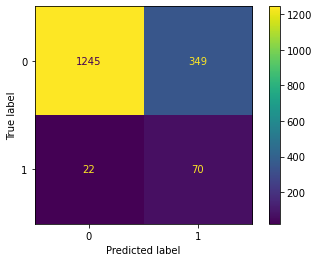

In [30]:
plot_confusion_matrix(model, X_test, y_test)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1594
           1       0.17      0.76      0.27        92

    accuracy                           0.78      1686
   macro avg       0.57      0.77      0.57      1686
weighted avg       0.94      0.78      0.84      1686



## Mixed type dataset
Now i made a dataset with age and avg_glucose level as continuous features, scaled using Z scores, and hypertension and heart disease as binary

In [32]:
selected_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'stroke']
df_mixed = df[selected_columns]
df_mixed['age'] = (df_mixed['age'] - df_mixed['age'].mean()) / df_mixed['age'].std()
df_mixed['avg_glucose_level'] = (df_mixed['avg_glucose_level'] - df_mixed['avg_glucose_level'].mean()) / df_mixed['avg_glucose_level'].std()

<ipython-input-32-f29d23c549a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mixed['age'] = (df_mixed['age'] - df_mixed['age'].mean()) / df_mixed['age'].std()
<ipython-input-32-f29d23c549a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mixed['avg_glucose_level'] = (df_mixed['avg_glucose_level'] - df_mixed['avg_glucose_level'].mean()) / df_mixed['avg_glucose_level'].std()


In [33]:
X = df_mixed.drop(['stroke'], axis=1)
y = df_mixed['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)

weights = {0:0.05, 1:1.0} # 0.02 : 1 finds all stroke labels, but a huge number of false positives as welll
model = SVC(gamma='scale', class_weight=weights)

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [34]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)

In [35]:
scores.mean()

0.21230505745480063

## Mixed dataset results
Recall was better, but false positives also increased.

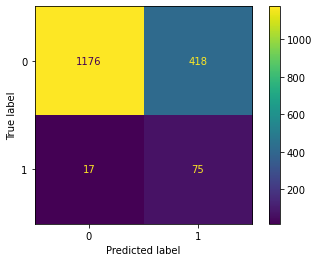

In [36]:
plot_confusion_matrix(model, X_test, y_test)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.74      0.84      1594
           1       0.15      0.82      0.26        92

    accuracy                           0.74      1686
   macro avg       0.57      0.78      0.55      1686
weighted avg       0.94      0.74      0.81      1686



## Feature selection based on feature importance from Naive Bayes

In [38]:
selected = ['ag_(75.0, 82.0]',
 'ag_(65.0, 75.0]',
 'av_(192.2, 271.7]',
 'hypertension',
 'heart_disease',
 'av_(124.1, 192.2]',
 'ag_(20.0, 30.0]',
 'ag_(-0.1, 11.0]',
 'ag_(30.0, 38.0]',
 'ag_(38.0, 45.0]',
 'av_(73.8, 80.0]',
 'av_(80.0, 85.6]',
 'stroke']

In [39]:
df_sel = df_dummies[selected]

In [40]:
X = df_sel.drop(['stroke'], axis=1)
y = df_sel['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)

weights = {0:0.05, 1:1.0} # 0.02 : 1 finds all stroke labels, but a huge number of false positives as welll
model = SVC(gamma='scale', class_weight=weights, probability=True)

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [41]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)

In [42]:
scores.mean()

0.22508552736832385

# Naive Bayes selected dataset results

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1594
           1       0.16      0.73      0.26        92

    accuracy                           0.77      1686
   macro avg       0.57      0.75      0.56      1686
weighted avg       0.94      0.77      0.83      1686



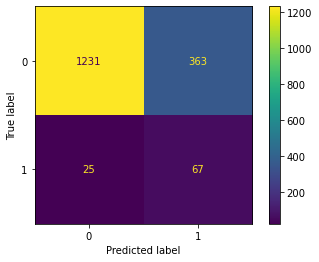

In [43]:
plot_confusion_matrix(model, X_test, y_test)
print(classification_report(y_test, y_pred))

## Mixed dataset with MCA feature added

In [44]:
import prince
mca_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'stroke', 'age_bin', 'avg_glucose_level_bin', 'bmi_bin']
df_mca = df[mca_cols]


In [45]:
mca = prince.MCA()
mca.fit(df_mca)
mca.transform(df_mca)

,0,1
0,-0.570810,-1.096147
1,-0.541514,-0.838423
2,-0.372545,-0.588579
3,-0.498542,-0.214096
4,-0.418910,-0.581785
...,...,...
5105,-0.457030,-0.309588
5106,-0.488111,-0.497988
5107,-0.342157,-0.003847
5108,-0.264469,0.039848


In [46]:
df_mixed_mca = pd.merge(df_mixed, mca.row_coordinates(df_mca), left_index=True, right_index=True)

In [47]:
X = df_mixed_mca.drop(['stroke'], axis=1)
y = df_mixed_mca['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=82)

weights = {0:0.05, 1:1.0} # 0.02 : 1 finds all stroke labels, but a huge number of false positives as welll
model = SVC(gamma='scale', class_weight=weights, probability=True)

model.fit(X_train, y_train)
labels = y.unique()

y_true = y_test
y_pred = model.predict(X_test)

In [48]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)

In [49]:
scores.mean()

0.26623184261244515

## 

              precision    recall  f1-score   support

           0       1.00      0.74      0.85      1594
           1       0.18      0.97      0.30        92

    accuracy                           0.76      1686
   macro avg       0.59      0.86      0.58      1686
weighted avg       0.95      0.76      0.82      1686



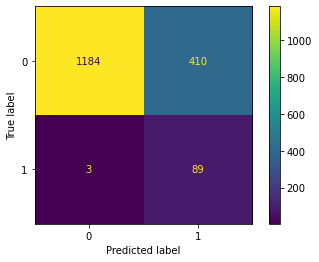

In [50]:
plot_confusion_matrix(model, X_test, y_test)
print(classification_report(y_test, y_pred))

## Garbage below
I was looking at cohen's kappa as a measure but it didn't seem very helpful. I also looked at the stroke cases we missed, they all seem much younger than the average stroke age.

In [51]:
from sklearn.metrics import cohen_kappa_score, roc_curve, f1_score

print(cohen_kappa_score(y_test, y_pred))

0.23025613247697896


In [52]:
check = pd.DataFrame(X_test)
check['probs'] = [*model.predict_proba(X_test)]
check['stroke'] = y_test

In [53]:
check[(check['stroke'] != y_pred) & (check['stroke'] == 1)]

,age,hypertension,heart_disease,avg_glucose_level,0,1,probs,stroke
39,0.255156,0,0,-0.998794,-0.431119,-0.112990,"[0.9808319627246203, 0.01916803727537975]",1
113,0.078272,0,0,2.604827,-0.518323,-0.309326,"[0.9755911973138488, 0.02440880268615117]",1
94,0.078272,0,0,-0.927468,-0.294594,-0.023135,"[0.9888252229804054, 0.011174777019594687]",1


In [54]:
check[(check['stroke'] == y_pred) & (check['stroke'] == 1) & (check['age'] < 60)]

,age,hypertension,heart_disease,avg_glucose_level,0,1,probs,stroke
63,0.078272,0,0,-0.274272,-0.392520,-0.303792,"[0.9364542229709941, 0.06354577702900584]",1
64,1.404904,0,0,-0.031366,-0.118916,-0.455515,"[0.8063840743208915, 0.19361592567910854]",1
171,1.581788,1,1,-0.998132,-0.463170,-0.960737,"[0.7952701306473775, 0.2047298693526227]",1
40,1.537567,0,0,-0.620744,-0.283592,-0.328852,"[0.8568918117286255, 0.14310818827137467]",1
76,1.626009,1,0,2.957924,-0.525775,-0.798697,"[0.7935577793265446, 0.20644222067345525]",1
...,...,...,...,...,...,...,...,...
67,1.449125,0,0,-0.036886,0.044077,-0.272096,"[0.9047051434681642, 0.09529485653183564]",1
187,1.714451,1,1,2.424635,-0.675378,-1.348888,"[0.8260906339017302, 0.1739093660982697]",1
148,0.608925,1,0,-0.855259,-0.456590,-0.449141,"[0.8943621673890453, 0.10563783261095484]",1
81,1.006914,0,0,-0.103575,-0.221026,-0.945344,"[0.46804801319891437, 0.5319519868010856]",1
